In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download ananthu017/emotion-detection-fer

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! unzip emotion-detection-fer

unzip:  cannot find or open emotion-detection-fer, emotion-detection-fer.zip or emotion-detection-fer.ZIP.


In [ ]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [ ]:
index = 1
plt.figure(figsize=(10, 5))
for classname in classes:
    class_dir = os.path.join(train_dir, classname)
    
    for filename in os.listdir(class_dir)[:1]:
        image = cv.imread(os.path.join(class_dir, filename))
        
        plt.subplot(1, len(classes), index)
        plt.title(classname)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        
        index += 1
        
plt.show()

FileNotFoundError: ignored

<Figure size 1000x500 with 0 Axes>

In [ ]:
images = []
image_classes = []
total_image_per_class = []

for classname in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, classname)
    
    for filename in os.listdir(class_dir):
        image = cv.imread(os.path.join(class_dir, filename))
        image = cv.resize(image, (224, 224))
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        images.append(image)
        image_classes.append(classname)
        
    total_image_per_class.append(len(os.listdir(class_dir)))
        
data = list(zip(images, image_classes))
len(data)
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=.2)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

In [ ]:
training_data = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  shuffle=True,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  subset='training',
                                                  seed=10)

validation_data = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    subset='validation',
                                                    seed=10)

testing_data = test_datagen.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                shuffle=False,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                # subset='training',
                                                seed=10)

In [ ]:
vgg19 = VGG19(input_shape = (224, 224, 3), weights = "imagenet", include_top = False)

In [ ]:
headModel = vgg19.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(classes), activation="softmax")(headModel)

In [ ]:
model = Model(inputs=vgg19.input, outputs=headModel)

In [ ]:
for layer in vgg19.layers:
  layer.trainable = False

In [ ]:
# compile model
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

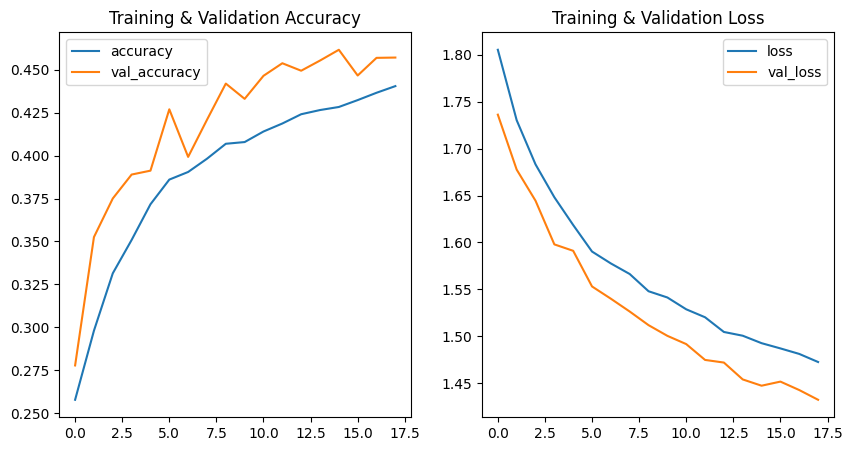

In [ ]:
visualize_history(history)

In [ ]:
model.evaluate(testing_data)

225/225 [==============================] - 83s 368ms/step - loss: 1.4361 - accuracy: 0.4579


[1.436078667640686, 0.45792698860168457]

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 93s 409ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.44      0.15      0.23       958
           1       0.00      0.00      0.00       111
           2       0.43      0.05      0.10      1024
           3       0.51      0.79      0.62      1774
           4       0.39      0.51      0.44      1233
           5       0.37      0.42      0.39      1247
           6       0.56      0.64      0.60       831

    accuracy                           0.46      7178
   macro avg       0.39      0.37      0.34      7178
weighted avg       0.44      0.46      0.41      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.4594594594594595
recall:  0.4594594594594595
precision:  0.4434038511145559
f1-score:  0.4122047431181319
Result =  0.4436318782879017


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for layer in vgg19.layers:
	layer.trainable = True

In [ ]:
for layer in vgg19.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7f59429ff2e0>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5942885480>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f594074d4e0>: True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f594074de40>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f594074f310>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f594074f2b0>: True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f594074d960>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f594074f520>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f593d79e140>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f593d79f160>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f593d79f730>: True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f593d79fa90>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f593d79c8b0>: True
<keras.layers.convolut

In [ ]:
# recompile model
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 489s 664ms/step - loss: 1.3736 - accuracy: 0.4782 - val_loss: 1.2742 - val_accuracy: 0.5180
Epoch 2/20
718/718 [==============================] - 461s 642ms/step - loss: 1.2621 - accuracy: 0.5208 - val_loss: 1.1845 - val_accuracy: 0.5522
Epoch 3/20
718/718 [==============================] - 460s 641ms/step - loss: 1.2041 - accuracy: 0.5454 - val_loss: 1.1427 - val_accuracy: 0.5739
Epoch 4/20
718/718 [==============================] - 456s 635ms/step - loss: 1.1505 - accuracy: 0.5660 - val_loss: 1.1162 - val_accuracy: 0.5802
Epoch 5/20
718/718 [==============================] - 453s 631ms/step - loss: 1.1182 - accuracy: 0.5789 - val_loss: 1.0911 - val_accuracy: 0.5980
Epoch 6/20
718/718 [==============================] - 452s 630ms/step - loss: 1.0794 - accuracy: 0.5949 - val_loss: 1.0688 - val_accuracy: 0.5926
Epoch 7/20
718/718 [==============================] - 453s 631ms/step - loss: 1.0561 - accuracy: 0.6047 - val_loss: 1.0538 -

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

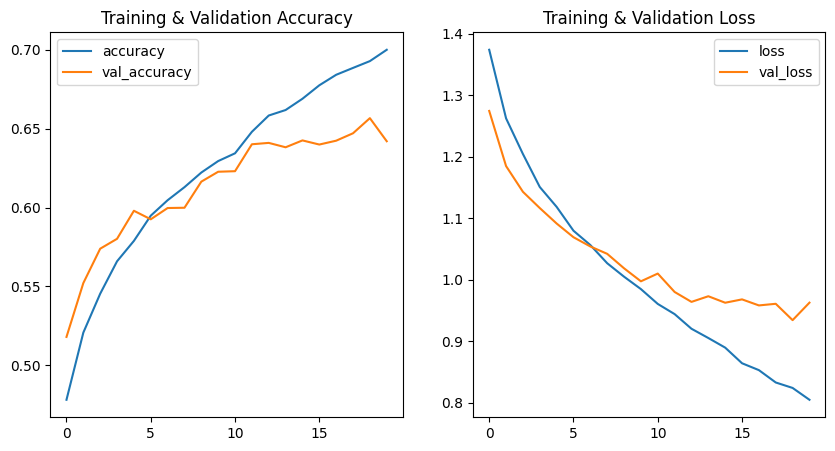

In [ ]:
visualize_history(history)

In [ ]:
model.evaluate(testing_data)

225/225 [==============================] - 99s 440ms/step - loss: 0.9702 - accuracy: 0.6427


[0.97017902135849, 0.6426581144332886]

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 88s 393ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       958
           1       0.70      0.25      0.37       111
           2       0.46      0.43      0.44      1024
           3       0.89      0.81      0.85      1774
           4       0.63      0.57      0.60      1233
           5       0.49      0.62      0.54      1247
           6       0.75      0.78      0.77       831

    accuracy                           0.64      7178
   macro avg       0.64      0.58      0.59      7178
weighted avg       0.65      0.64      0.64      7178



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.6380607411535246
recall:  0.6380607411535246
precision:  0.6494594076085493
f1-score:  0.6399353640590397
Result =  0.6413790634936596


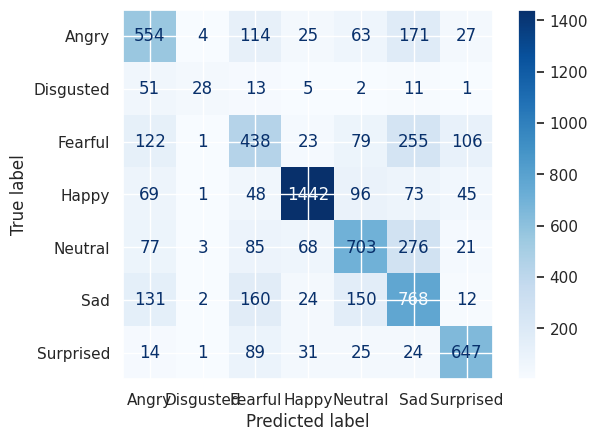

In [ ]:
# from sklearn import metrics
# import matplotlib.pyplot as plt
# cm = metrics.confusion_matrix(y_actual, y_pred_labels)
# emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
# disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_dict.values())
# disp.plot(cmap = 'Blues', values_format='d', xticks_rotation='horizontal', ax=None, colorbar=True)

# plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_actual, y_pred_labels)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt="g", xticklabels=emotion_dict.values(), yticklabels=emotion_dict.values())
ax.set_title('Confusion Matrix', fontdict=title_font)
sns.set(font_scale=1)
title_font = {'size':'10'}
plt.show()